# Optical Character Recognition (OCR) from Scratch

## Introduction
Here, we explore building a basic OCR system using convolutional neural networks. While commercial projects might leverage tools like Tesseract, building from scratch gives insights into the challenges and processes involved.

## Goals/Objectives
- Understand the intricacies of building an OCR model.
- Gain hands-on experience in handling image data and training image classification models.

## Dataset Overview
We'll use the [EMNIST ByClass dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset) for this project. This dataset contains 814,255 characters, both digits and letters.


In [ ]:
# install tensorflow dataset
!pip install tensorflow-datasets

# imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np


# Data Loading & Exploration

The EMNIST (Extended MNIST) dataset is an expansion of the original MNIST dataset. The EMNIST ByClass dataset contains 814,255 characters, both digits and letters. It's crucial to first load the dataset and visualize its samples to get a better understanding of the data we are dealing with.

## Personal Notes:
- Always begin by loading and understanding the dataset. Visualization helps to get an intuitive sense of the data.

Let's start by loading the EMNIST dataset and visualizing some samples from it.


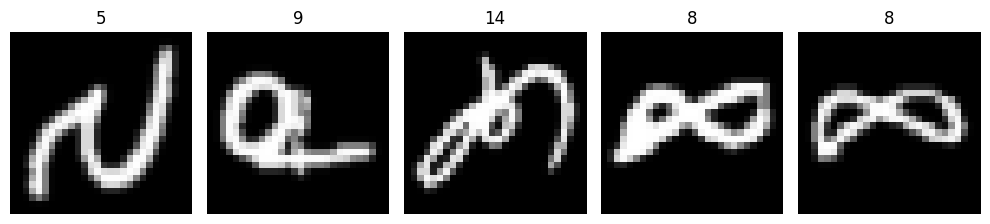

In [ ]:

# Load the EMNIST dataset
(train_data, test_data), dataset_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,  # This will return tuple (img, label) otherwise it returns a dictionary
    with_info=True  # Provides tuple containing info about version, features, num_samples
)

# Visualize some sample data from the dataset
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(train_data.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.gray)
    plt.title(label.numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()


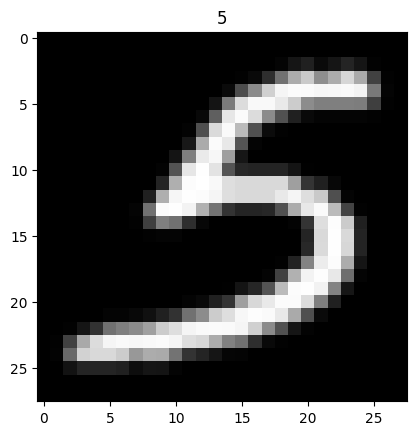

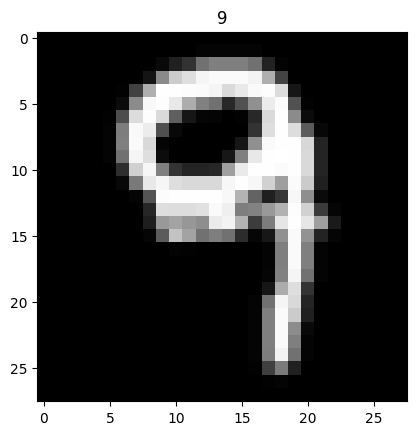

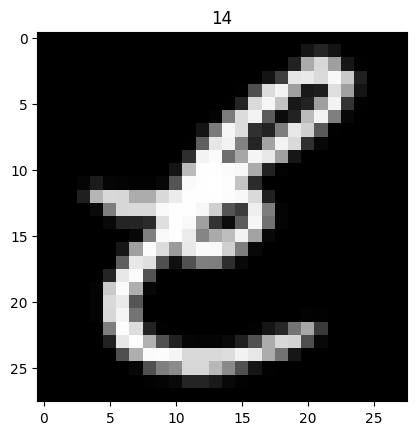

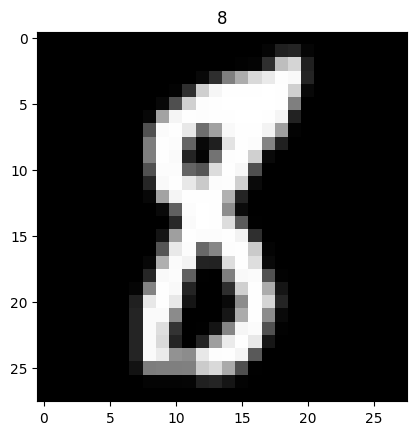

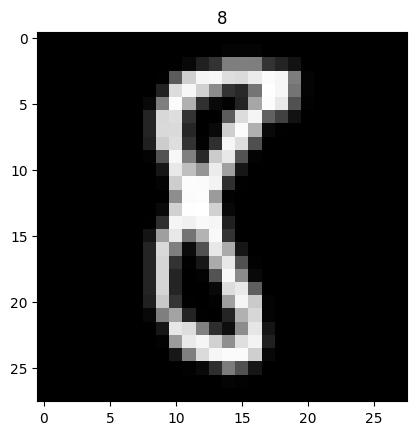

In [ ]:
# fix orientation
import numpy as np

for image, label in train_data.take(5):
    # Correct the orientation
    image = np.rot90(image.numpy().squeeze(), -1)
    image = np.fliplr(image)

    plt.figure()
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(label.numpy())


# Data Preprocessing

Before we can feed the images into our model, it's crucial to preprocess them to ensure they are in a suitable format. In the case of the EMNIST dataset, the images are rotated, and we need to correct their orientation.

## Personal Notes:
- Image data often requires preprocessing steps such as resizing, normalization, or orientation correction.
- Preprocessing can impact model performance. It's essential to know the dataset's characteristics and apply appropriate preprocessing.

Let's correct the orientation of the images.

### Normalization

In [ ]:
# Access a batch of images and labels from train_data for visualization or processing
for images, labels in train_data.take(1):
    normalized_images = images.numpy() / 255.0

### Reshaping

In [ ]:
# inspect the shape of images in dataset

for images, labels in train_data.take(1):  # Taking one batch from the dataset
    print('Image shape (height, width, channels) : ', images.shape)

Image shape (height, width, channels) :  (28, 28, 1)


Already in the desired shape

*Personal notes: In TensorFlow (and also in numpy), when you're reshaping, the -1 is effectively used as a placeholder that says "whatever is needed", so TensorFlow will automatically compute the correct number for that dimension.*


### Orientation Correction:

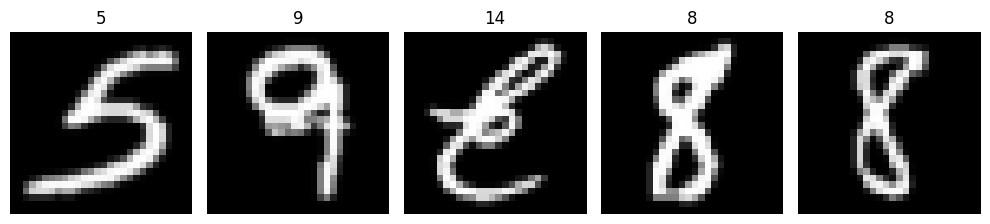

In [ ]:

def correct_orientation(image, label):
    # Rotate by 270 degrees (equivalent to -90 degrees) and flip left-right
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)
    return image, label

corrected_train_data = train_data.map(correct_orientation)

# Visualize some sample data after orientation correction
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(corrected_train_data.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.gray)
    plt.title(label.numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()



# Label Encoding

In machine learning, we often encode categorical labels into a format that could be provided to ML algorithms to do a better job in prediction. One common way is one-hot encoding. One-hot encoding is a process by which categorical variables are converted into a format that can be fed to ML algorithms to improve predictions.

For the EMNIST dataset, the labels represent different classes of characters, and these are categorical. Hence, we need to one-hot encode them.

## Personal Notes:
- One-hot encoding is a process to convert integer labels into a binary matrix. For example, if the dataset has three classes and an input sample belongs to the second class, its one-hot encoded label would be [0, 1, 0].
- This binary matrix representation can be used as input to a neural network.

Let's proceed with the one-hot encoding of the labels.


In [ ]:
def encode_labels(image, label):
    # One-hot encode the labels using tf.one_hot
    num_classes = dataset_info.features['label'].num_classes
    one_hot_label = tf.one_hot(label, depth=num_classes)
    return image, one_hot_label

encoded_train_data = corrected_train_data.map(encode_labels)

# Extract a sample for visualization
original_sample = next(iter(tfds.as_numpy(corrected_train_data.take(1))))
encoded_sample = next(iter(tfds.as_numpy(encoded_train_data.take(1))))

original_label = original_sample[1]
one_hot_encoded_label = encoded_sample[1]

original_label, one_hot_encoded_label


(5,
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))


# Balancing the Dataset

Class imbalance is a common problem in machine learning classification. If the number of samples in different classes is imbalanced, the model could be biased towards the class with more samples, leading to suboptimal performance.

In the context of the EMNIST dataset, it's essential to ensure that each character class has roughly the same number of samples.

## Personal Notes:
- An imbalanced dataset can lead the model to be more biased towards the class with more samples. This could result in reduced accuracy for the minority classes.
- Oversampling and undersampling are two common techniques to handle imbalance. Oversampling increases the number of minority class samples, while undersampling reduces the number of majority class samples.

Let's inspect the distribution of classes in our dataset and balance it if necessary.


In [ ]:
# Inspect the class distribution
class_distribution = {}

for _, label in tfds.as_numpy(encoded_train_data):
    label_index = np.argmax(label)
    class_distribution[label_index] = class_distribution.get(label_index, 0) + 1

# Display the class distribution
class_distribution


{5: 31416,
 9: 33847,
 14: 4934,
 8: 33946,
 0: 34585,
 7: 35754,
 39: 10177,
 40: 24631,
 1: 38374,
 35: 2701,
 15: 9182,
 3: 35143,
 53: 14105,
 24: 24983,
 31: 4637,
 17: 3152,
 26: 2605,
 52: 2994,
 33: 2771,
 37: 5159,
 42: 3687,
 6: 34232,
 59: 2822,
 43: 8738,
 18: 11946,
 49: 11418,
 34: 4743,
 2: 34203,
 36: 10033,
 47: 15318,
 21: 5076,
 30: 12602,
 38: 2854,
 16: 2517,
 57: 2910,
 32: 4695,
 55: 18262,
 23: 8237,
 4: 33535,
 19: 3762,
 10: 6407,
 27: 5073,
 29: 9820,
 12: 10094,
 60: 2365,
 13: 4562,
 28: 20764,
 48: 2645,
 54: 2699,
 50: 2749,
 45: 1896,
 56: 2830,
 25: 8347,
 41: 2561,
 44: 2725,
 20: 2468,
 61: 2725,
 22: 9002,
 46: 2491,
 58: 2697,
 51: 2448,
 11: 3878}